<a href="https://colab.research.google.com/github/ajalamarvellous/starch-microscopical-analysis/blob/main/Cognosy_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Microscopical starch analysis with computer vision


The goal of this project is to implement a computer vision algorithm to accurately classify different starches (9 different starches: ) based on their microscopical images


##Importing neccesary and important libraries to be used



In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time

import tqdm as tqdm
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models, datasets

##Connecting the google drive where the images are located

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


seeding the variables to enable reproducibility of the codes

In [ ]:
def seedall(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  os.environ['PYTHONHASHSEED'] = str(seed)

seedall(17)

setting some parameters


In [ ]:
#seeting batch size to 16
batch_size = 8

#number of subprocesses to run simultaneously
num_workers = 0

#size of validation
val_size = 0.3

#directory path to images
path = "drive/MyDrive/Blessings/"

## Loading the data

In [ ]:
#applying trasformations to the images
transform = transforms.Compose([transforms.RandomHorizontalFlip(),      #randomly flip some images
                                transforms.RandomRotation(10),          #randomly rotate some images
                                transforms.Resize([224, 224]),          #resize the images to height = 224, width = 224
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

#loading the dataset
data = datasets.ImageFolder(path, transform= transform)

#obtaining training and validation datasets
num_train = len(data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

#preparing the data loaders (combine data and sampler)
train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(data, batch_size = batch_size,
                                           sampler = test_sampler, num_workers = num_workers)

Functions to help sort challenges with picture formats

In [ ]:
%matplotlib inline

#helper function to unnormalize the data and convert from tensors
def imshow(img):
  img = img/ 2 + 0.5   #unnormalize
  plt.imshow(np.transpose(img, (1,2, 0)))  #convert from Tensor

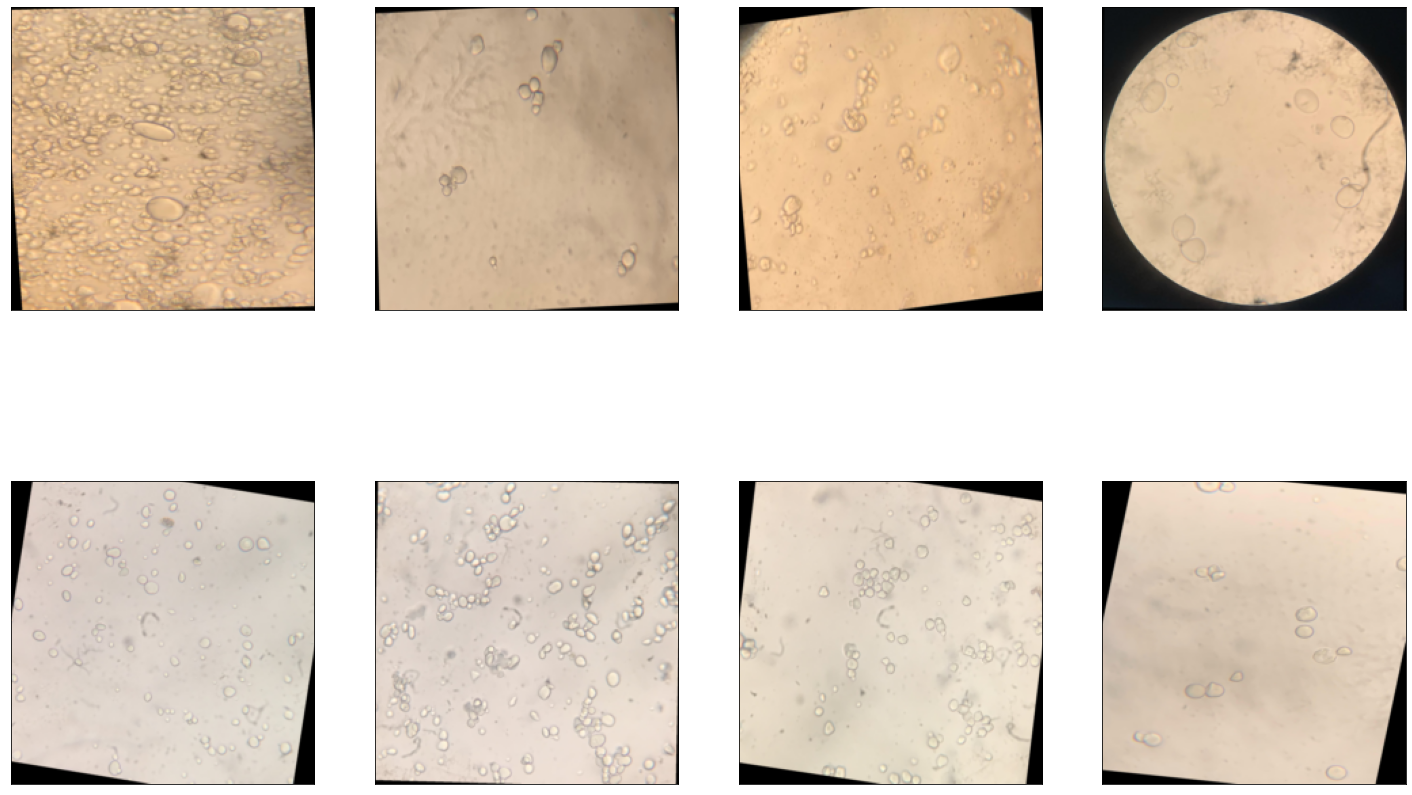

In [ ]:
#obtain one batch of images
images, labels = next(iter(train_loader))
images = images.numpy() # to convert to numpy for display

#plot the images alongside with their labels
fig = plt.figure(figsize = (25,16))
for idx in np.arange(8):
  ax = fig.add_subplot(2, 4, idx +1, xticks =[], yticks = [])
  imshow(images[idx])

## Defining the architectures (the AI algorithms)

## A.) Fully Connected Neural Network

defining our fully connected neural network

In [ ]:
n0 = 3* 224* 224    #multiplication of the number of layers of the images (3 for red, blue and green) by the dimensions of the images (224*224)
n1 = 3000          #number of nodes in first layer
n2 = 1500          #number of nodes in first layer
n3 = 750          #number of nodes in first layer
n4 = 200           #number of nodes in second layer
outlayer = 9       #number of nodes in output layer
multilayerperceptron = nn.Sequential(nn.Linear(n0, n1 ),
                                     nn.ReLU(),
                                     nn.Dropout(p= 0.2),
                                     nn.Linear(n1, n2),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.2),
                                     nn.Linear(n2, n3),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.2),
                                     nn.Linear(n3, n4),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.2),
                                     nn.Linear(n4, outlayer),
                                     nn.LogSoftmax(dim=1))
multilayerperceptron

Sequential(
  (0): Linear(in_features=150528, out_features=3000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=3000, out_features=1500, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=1500, out_features=750, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=750, out_features=200, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=200, out_features=9, bias=True)
  (13): LogSoftmax(dim=1)
)

Training our fully connected neural network

In [ ]:
epoch = 30        # number of epochs to run
lr = 0.0025         #how big a step our model should take in adjusting the errors
train_loss, valid_loss, valid_accuracy = [],[],[]   #placeholders for the training loss, validation loss and validation accuracy
model  = multilayerperceptron     #intiating the algorithm
criterion = nn.NLLLoss()          #initiating the loss function
optimizer = optim.Adam(model.parameters(), lr = lr)   #initiating the optimizer to Adam
device = "cuda"                   #setting device to cuda to maximize the GPU

beg = time.time()
for i in range(epoch):
  model.train
  loss = 0
  train_counter = 0
  for images, labels in train_loader:
    train_counter += 1
    #moving the model and data to GPU
    model, images, labels = model.to(device), images.to(device), labels.to(device)
    images = images.view(images.shape[0], -1)     #reshaping the images to batch_size, 3*224*224
    optimizer.zero_grad()         #clearing all the backprop values available
    start_x = time.time()
    forward = model(images)       #performing forward propagation
    epoch_loss = criterion(forward, labels)     #comparing result from our forward propagation to the original labels
    epoch_loss.backward()      #performing backpropagation
    optimizer.step()            #adjusting the error obtained to the original value at rate lr
    end_x = time.time()
    loss += epoch_loss.item()
  
  loss = loss/train_counter
  train_loss.append(loss)

  val_loss = 0
  accuracy= 0
  with torch.no_grad():
    for sample, labels in test_loader:
      sample = sample.view(sample.shape[0], -1)     #reshaping the images to batch_size, 3*224*224
      sample, labels = sample.to(device), labels.to(device)
      forward = model(sample)
      val_loss = criterion(forward, labels)
      val_loss = val_loss.item()
      forward = F.softmax(forward, dim= 1)
      top_k, top_class = forward.topk(1, dim= 1)
      eval = labels == top_class.view(labels.shape)
      accuracy = torch.mean(eval.type(torch.FloatTensor))

  val_loss /= len(test_loader)
  valid_loss.append(val_loss)
  valid_accuracy.append(accuracy)

  print(f"Epoch {i+1}/{epoch}...... training loss {loss}....validation loss {val_loss}....validation accuracy {accuracy}....time taken {end_x - start_x} secs")
  print("-"*100, "/n")
ending = time.time()
print(f'The total training time for this model was {beg - ending} secs')

Epoch 1/30...... training loss 11.195729239781697....validation loss 0.07400933901468913....validation accuracy 0.0....time taken 0.0051953792572021484 secs
---------------------------------------------------------------------------------------------------- /n
Epoch 2/30...... training loss 1.9959750003284877....validation loss 3.615936596664445e-06....validation accuracy 1.0....time taken 0.0035355091094970703 secs
---------------------------------------------------------------------------------------------------- /n
Epoch 3/30...... training loss 1.7533253961139255....validation loss 0.3890788157780965....validation accuracy 0.0....time taken 0.0034923553466796875 secs
---------------------------------------------------------------------------------------------------- /n
Epoch 4/30...... training loss 2.2366195652219982....validation loss 0.07394049564997356....validation accuracy 1.0....time taken 0.003342151641845703 secs
------------------------------------------------------------

plotting the loss functions and accuracy

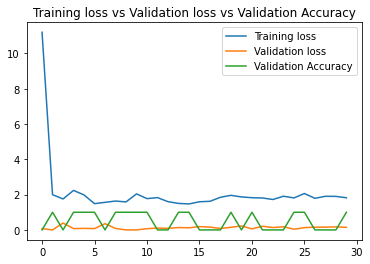

In [ ]:
plt.plot(train_loss, label = "Training loss")
plt.plot(valid_loss, label = "Validation loss")
plt.plot(valid_accuracy, label = "Validation Accuracy")
plt.legend()
plt.title("Training loss vs Validation loss vs Validation Accuracy")
plt.show()

## B.) Custom Convolution Neural Network (convnet)

defining our convnets

In [ ]:
class CustomConvnet(nn.Module):
  def __init__(self):
    super(CustomConvnet, self).__init__()
    # convolution layer (sees 224 * 224 * 3 image tensor)
    self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
    # convolution layer (sees 112 * 112 * 16 image tensor)
    self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
    # convolution layer (sees 56 * 56 * 32 image tensor)
    self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
    # convolution layer (sees 28 * 28 * 64 image tensor)
    self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
    # convolution layer (sees 14 * 14 * 128 image tensor)
    self.conv5 = nn.Conv2d(128, 256, 3, padding = 1)
    # convolution layer (sees 7 * 7 * 256 image tensor)
    self.conv6 = nn.Conv2d(256, 512, 3, padding = 1)
    # maxpool (reduce by 2 by 2)
    self.pool = nn.MaxPool2d(2,2)
    # linear layer1 (7 * 7 * 512 --> 8192)
    self.fc1 = nn.Linear(7 * 7 * 512, 500)
    # output layer (500, outputclass)
    self.out = nn.Linear(500, 3)
    # dropout layer (p = 0.2)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, x):
    # adding sequence of the convolution and linear layers
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = self.pool(F.relu(self.conv5(x)))
    x = F.relu(self.conv6(x))
    # flattening the image input
    x = x.view(-1, 7 * 7 * 512)
    # adding the dropout layer
    x = self.dropout(x)
    # adding the first linear option
    x = F.relu(self.fc1(x))
    # adding another dropout layer
    x = self.dropout(x)
    #adding the output layer
    x = F.relu(self.out(x))
    return x

# create the complete CNN
model = CustomConvnet()
print(model)

CustomConvnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


option b.) Training our custom model

In [ ]:
# number of epochs 
epoch = 30
#learning rate to use
lr = 0.0025
# setting model to our custom convnet
model = CustomConvnet()
# placeholder for the training loss, validation loss and validation accuracy
train_loss, val_loss, val_accuracy = [], [], []
#initiating loss function
criterion  = nn.CrossEntropyLoss()
#intiating the optimizer to Adam
optimizer = optim.Adam(model.parameters(), lr = lr)
# setting the device to cuda to utilize the GPU
device = "cuda"

#place holder for starting time of the model
beg_time = time.time()
for x in range(epoch):
  #setting to train mode
  model.train
  #place holder for loss function
  loss = 0
  # place holder to count number of epochs run
  train_counter = 0
  # loading the images and labels from the train loader
  for images, labels in train_loader:
    train_counter +=1
    #moving the model, images and labels to GPU
    model, images, labels = model.to(device), images.to(device), labels.to(device)
    #clearing the backprop gradient
    optimizer.zero_grad()
    #calculating training time
    start = time.time()
    #running the forward propagation
    forward = model.forward(images)
    #calculating the loss function
    epoch_loss = criterion(forward, labels)
    # backpropagation
    epoch_loss.backward()
    # optimizing step
    optimizer.step()
    # getting the value for loss function
    loss += epoch_loss.item()
    #training time end
    end = time.time()
  
  loss /= train_counter
  train_loss.append(loss)
  
  valid_loss = 0
  valid_accuracy = 0
  model.eval()
  with torch.no_grad():
    for images, labels in test_loader:
      #moving images and labels to GPU
      images, labels = images.to(device), labels.to(device)
      #getting the output prediction
      output = model(images)
      # loss function
      valid_loss = criterion(output, labels)
      valid_loss += valid_loss.item()
      # getting output classification
      output = F.log_softmax(output, dim = 1)
      top_k, top_class = output.topk(1, dim = 1)
      eval = labels == top_class.view(labels.shape)
      #getting the accuracy
      valid_accuracy = torch.mean(eval.type(torch.FloatTensor))

  valid_loss /= len(test_loader)
  val_loss.append(valid_loss)
  val_accuracy.append(valid_accuracy)

  print(f"Epoch {x+1}/{epoch}...... training loss {loss}....validation loss {valid_loss}....validation accuracy {valid_accuracy}....time taken {end_x - start_x} secs")
  print("-"*100, "\n")
ending = time.time()
print(f'The total training time for this model was {(beg - ending)/ 60} mins')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


RuntimeError: ignored

## C.) Transfer learning (using predefined models trained on Imagenet)

defined the pretrained models we will be using


In [ ]:
import torchvision.models as models

In [ ]:
# importing vgg-11 model
#vgg11 = models.vgg11(pretrained = True)

#importing vgg-13 model
#vgg13 = models.vgg13(pretrained = False)

#importing vgg-16 model
#vgg16 = models.vgg16(pretrained = True)

#importing resnet-18 model
#resnet18 = models.resnet18(pretrained = True)

#importing resnet-34 model
#resnet34 = models.resnet34(pretrained = True)

#importing resnet-50 model
resnet50 = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
n0 = 2048
n1 = 500
n2 = 100
n3 = 9
classifier = nn.Sequential(nn.Linear(n0, n1),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(n1, n2),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(n2, n3))

## Early stopping

Defining an optimization technique, early stopping. By using early stoppage, our model will stop training ones the model isn't getting any better and will save automatically

In [ ]:
class Earlystopping:
  """ stops the model ones it isn't getting any better"""
  def __init__(self, patience = 5, verbose = False, delta = 0):

    """ patience: how long the model should wait to see if the model is improving
        verbose: boolean to print message whenever validatio loss reduce
        delta: minimum change to occur in quantified quantity to know change has occurred"""

    self.patience = patience
    self.verbose = verbose
    self.delta = delta
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf

  def __call__(self, val_loss, model):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score 
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.counter += 1
      print(f"Early stopping counter: {self.counter} out of {self.patience}")
      if self.counter >=self.patience:
        self.early_stop = True

    else:
      self.best_score = score 
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):
    """"saves model when the validation loss decreases"""
    if self.verbose:
      print(f"validation loss decreased from ({self.val_loss_min:.6f} -->  {val_loss:.6f}.   saving model......")
    if os.path.exists("/content/drive/MyDrive/models") == False:
      os.mkdir("/content/drive/MyDrive/models")
    torch.save(model.state_dict(), "/content/drive/MyDrive/models/"+f"{model_name}_best_model.pth")
    self.val_loss_min = val_loss

Training the predefined model

In [ ]:
resnet50.classifier = classifier

loading the model to avoid training from the beginning again

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.15.weight', 'features.15.bias', 'features.17.weight', 'features.17.bias', 'features.20.weight', 'features.20.bias', 'features.22.weight', 'features.22.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


<All keys matched successfully>

Epoch 1/30....training loss 1.5772......validation loss0.006514612804440891.......validation accuracy 1.0
validation loss decreased from (inf -->  0.006515.   saving model......
____________________________________________________________________________________________________
Epoch 2/30....training loss 2.5531......validation loss0.04515422792995677.......validation accuracy 1.0
Early stopping counter: 1 out of 5
____________________________________________________________________________________________________
Epoch 3/30....training loss 1.5501......validation loss0.04605246642056633.......validation accuracy 0.5
Early stopping counter: 2 out of 5
____________________________________________________________________________________________________
Epoch 4/30....training loss 1.3384......validation loss0.04828121732263004.......validation accuracy 0.5
Early stopping counter: 3 out of 5
___________________________________________________________________________________________________

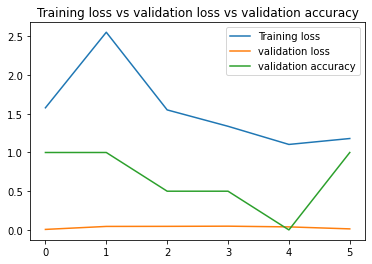

In [ ]:
model_name = "resnet50"
dir_path = "models/"
lr = 0.001
epoch = 30
train_loss, val_loss, val_accuracy = [],[],[]
model = resnet50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
device = "cuda"
early_stopping = Earlystopping(patience= 5, verbose = True)
#model.to(device)

start = time.time()
for x in range(epoch):
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
  loss = 0
  counter = 0
  for images, labels in train_loader:
    optimizer.zero_grad()
    counter +=1
    #images, labels = images.to(device), labels.to(device)
    forward = model(images)
    epoch_loss = criterion(forward, labels)
    epoch_loss.backward()
    loss += epoch_loss.item()
    optimizer.step()

  loss /= counter 
  train_loss.append(loss)

  valid_loss = 0
  valid_accuracy = 0
  model.eval()
  with torch.no_grad():
    for images, labels in test_loader:
      #images, labels = images.to(device), labels.to(device)
      forward = model(images)
      valid_loss = criterion(forward, labels)
      valid_loss = valid_loss.item()
      forward = F.softmax(forward, dim = 1)
      top_k, top_class = forward.topk(1, dim = 1)
      eval = labels == top_class.view(labels.shape)
      valid_accuracy = torch.mean(eval.type(torch.FloatTensor))

  valid_loss /= len(test_loader)
  val_loss.append(valid_loss)
  val_accuracy.append(valid_accuracy)
  print(f"Epoch {x+1}/{epoch}....training loss {loss:.4f}......validation loss{valid_loss}.......validation accuracy {valid_accuracy}")
  early_stopping(valid_loss, model)
  print("_"*100)
  if early_stopping.early_stop:
    print(f"Early stopping at epoch {x}.............")
    break
end = time.time()
print(f"Total time taken was{(end- start)/60} mins")

plt.plot(train_loss, label = "Training loss")
plt.plot(val_loss, label = "validation loss")
plt.plot(val_accuracy, label = "validation accuracy")
plt.legend()
plt.title("Training loss vs validation loss vs validation accuracy")
plt.show()
model_scores[model_name] = -early_stopping.best_score

In [ ]:
#model_scores = {}
model_scores

{'resnet18': 0.006334976238362929,
 'resnet34': 0.011757038971957038,
 'resnet50': 0.006514612804440891,
 'vgg13': 0.06021259812747731,
 'vgg16': 0.06344312780043658}

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/models/resnet18_best_model.pth")
print(state_dict.keys())

#importing resnet-18 model
resnet18 = models.resnet18(pretrained = False)
print(resnet18)

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [ ]:
n0 = 512
n1 = 250
n2 = 100
n3 = 9
classifier = nn.Sequential(nn.Linear(n0, n1),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(n1, n2),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(n2, n3))

In [ ]:
resnet18.classifier = classifier
model = resnet18

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
#seeting batch size to 16
batch_size = 32

#number of subprocesses to run simultaneously
num_workers = 0

#directory path to images
path = "drive/MyDrive/Blessings/"

#applying trasformations to the images
transform = transforms.Compose([transforms.Resize([224, 224]),          #resize the images to height = 224, width = 224
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

#loading the dataset
data = datasets.ImageFolder(path, transform= transform)

loader_all = torch.utils.data.DataLoader(data, batch_size = batch_size,
                                         num_workers = num_workers)

In [ ]:
pip install tqdm

In [ ]:
print(len(data)/loader_all.batch_size)

27.78125


In [ ]:
import tqdm as tqdm
criterion = nn.CrossEntropyLoss()

valid_loss = 0
valid_accuracy = 0
model.eval()
prediction, correct_label = [], []

total_accuracy = 0
counter = 0
start = time.time()
with torch.no_grad():
  for images, labels in loader_all:
    counter +=1
    #images, labels = images.to(device), labels.to(device)
    forward = model(images)
    valid_loss = criterion(forward, labels)
    valid_loss += valid_loss.item()
    forward = F.softmax(forward, dim = 1)
    top_k, top_class = forward.topk(1, dim = 1)
    eval = labels == top_class.view(labels.shape)
    valid_accuracy = torch.mean(eval.type(torch.FloatTensor))
    total_accuracy += valid_accuracy
    prediction.append(top_class)
    correct_label.append(labels)
    print(f"Epoch {counter} done out of {len(data)/loader_all.batch_size}, {len(data)/loader_all.batch_size - counter} to go.......")

  valid_loss /= len(loader_all)
print(f"The accuracy of the model after being tested on all the data is: {total_accuracy/np.ceil(len(data)/loader_all.batch_size)}...with validation loss: {valid_loss}")

end = time.time()
print(f"Total time taken was{(end- start)/60} mins")


Epoch 1 done out of 27.78125, 26.78125 to go.......
Epoch 2 done out of 27.78125, 25.78125 to go.......
Epoch 3 done out of 27.78125, 24.78125 to go.......
Epoch 4 done out of 27.78125, 23.78125 to go.......
Epoch 5 done out of 27.78125, 22.78125 to go.......
Epoch 6 done out of 27.78125, 21.78125 to go.......
Epoch 7 done out of 27.78125, 20.78125 to go.......
Epoch 8 done out of 27.78125, 19.78125 to go.......
Epoch 9 done out of 27.78125, 18.78125 to go.......
Epoch 10 done out of 27.78125, 17.78125 to go.......
Epoch 11 done out of 27.78125, 16.78125 to go.......
Epoch 12 done out of 27.78125, 15.78125 to go.......
Epoch 13 done out of 27.78125, 14.78125 to go.......
Epoch 14 done out of 27.78125, 13.78125 to go.......
Epoch 15 done out of 27.78125, 12.78125 to go.......
Epoch 16 done out of 27.78125, 11.78125 to go.......
Epoch 17 done out of 27.78125, 10.78125 to go.......
Epoch 18 done out of 27.78125, 9.78125 to go.......
Epoch 19 done out of 27.78125, 8.78125 to go.......
Epoc

In [ ]:
final = []
for x in range(1, 10):
  o =[]
  for y in range(9):
    a = str(x)+str(y)
    o.append(int(a))
  final.append(np.array(o))

  #final = [i.squeeze().tolist() for i in final]
  #final = [i for i in o]
print(final)

new_final = []
for c in final:
  for d in c:
    new_final.append(d)

print(new_final)

[array([10, 11, 12, 13, 14, 15, 16, 17, 18]), array([20, 21, 22, 23, 24, 25, 26, 27, 28]), array([30, 31, 32, 33, 34, 35, 36, 37, 38]), array([40, 41, 42, 43, 44, 45, 46, 47, 48]), array([50, 51, 52, 53, 54, 55, 56, 57, 58]), array([60, 61, 62, 63, 64, 65, 66, 67, 68]), array([70, 71, 72, 73, 74, 75, 76, 77, 78]), array([80, 81, 82, 83, 84, 85, 86, 87, 88]), array([90, 91, 92, 93, 94, 95, 96, 97, 98])]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98]


In [ ]:
#seeting batch size to 16
batch_size = 32

#number of subprocesses to run simultaneously
num_workers = 0

#directory path to images
path = "/content/drive/MyDrive/Blessings/"

starches = ["CAS", "Green peas starch granules", "IRP", "MAZ", "Millet starch granules", "OAT", "RIC", "WHZ", "Tiger nut starch granules"]

#applying trasformations to the images
transform = transforms.Compose([transforms.Resize([224, 224]),          #resize the images to height = 224, width = 224
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])
start = time.time()
for starch in starches:
  
  #loading the dataset
  data = datasets.ImageFolder(os.path.join(path,starch), transform= transform)

  loader_all = torch.utils.data.DataLoader(data, batch_size = batch_size,
                                         num_workers = num_workers)

  criterion = nn.CrossEntropyLoss()

  valid_loss = 0
  valid_accuracy = 0
  model.eval()
  prediction, correct_label = [], []

  total_accuracy = 0
  counter = 0
  
  with torch.no_grad():
    for images, labels in loader_all:
      counter +=1
      #images, labels = images.to(device), labels.to(device)
      forward = model(images)
      valid_loss = criterion(forward, labels)
      valid_loss += valid_loss.item()
      forward = F.softmax(forward, dim = 1)
      top_k, top_class = forward.topk(1, dim = 1)
      eval = labels == top_class.view(labels.shape)
      valid_accuracy = torch.mean(eval.type(torch.FloatTensor))
      total_accuracy += valid_accuracy
      prediction.append(top_class)
      correct_label.append(labels)
      print(f"Epoch {counter} done out of {len(data)/loader_all.batch_size}, {len(data)/loader_all.batch_size - counter} to go.......")

    valid_loss /= len(test_loader)
  print(f"The accuracy of the model on {starch} is......... {total_accuracy/np.ceil(len(data)/loader_all.batch_size)}")

end = time.time()
print(f"Total time taken was{(end- start)/60} mins")

   

FileNotFoundError: ignored

In [ ]:
os.path.exists("/content/drive/MyDrive/Blessings/CAS")

True

In [ ]:
y_true = []
for x in correct_label:
  x= x.numpy()
  for y in x:
    y_true.append(y)

In [ ]:
print(len(y_true))
print(y_true[:20])

889
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
y_pred = []
for x in prediction:
  x= x.numpy().flatten()
  print(x)
  for y in x:
    y_pred.append(y)

print(len(y_pred))

[3 1 1 1 3 1 1 1 7 7 7 7 1 1 3 3 3 1 3 3 3 1 7 1 3 3 0 3 3 1 3 3]
[1 3 3 3 1 0 0 1 1 1 7 7 1 1 3 0 3 3 3 1 1 1 1 1 1 7 7 0 1 3 3 3]
[3 1 1 3 0 1 0 1 1 1 3 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 3 3 0 1 0 0]
[1 3 3 3 1 7 1 1 1 1 1 7 7 7 1 7 7 1 7 7 1 1 7 7 1 7 7 7 1 1 7 7]
[7 1 7 7 7 7 7 7 1 7 1 7 7 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1 7 3 3 1 1 1 1 1 1 1 1 7 1 1]
[1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 1 1 7 1 1 7 1 1 1 1 7 1 2 3 3 2 2]
[3 2 3 2 2 2 2 2 3 2 2 3 3 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 6 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 1 3 3]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 3 3 3 3 3 3 3 3 3 3 3 3 0]
[0 3 3 7 7 1 7 7 7 7 7 7 7 7 7 1 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 1]
[7 7 7 1 7 7 7 7 7 7 7 7 1 1 7 7 1 7 7 7 7 7 7 7 7 7 1 7 7 7 1 7]
[7 7 7 7 7

In [ ]:
y_true =np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names = starches))

                            precision    recall  f1-score   support

                       CAS       0.92      0.23      0.37       100
Green peas starch granules       0.56      0.71      0.62       119
                       IRP       0.99      0.87      0.93       100
                       MAZ       0.63      0.88      0.73       100
    Millet starch granules       0.00      0.00      0.00       103
                       OAT       1.00      0.70      0.83        81
                       RIC       0.98      0.54      0.70        91
                       WHZ       0.45      0.96      0.61       112
 Tiger nut starch granules       0.58      0.96      0.72        83

                  accuracy                           0.65       889
                 macro avg       0.68      0.65      0.61       889
              weighted avg       0.66      0.65      0.60       889



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
